In [9]:
import tensorflow.compat.v1 as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from functools import reduce
from scipy import signal
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras as K
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, BatchNormalization, PReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import datetime
import pickle
import scipy
import h5py
get_ipython().run_line_magic('load_ext', 'tensorboard')
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
get_ipython().run_line_magic('matplotlib', 'inline')
from collections import Counter
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
np.random.seed(42)
tf.set_random_seed(42)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=36)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=30)
    plt.yticks(tick_marks, classes, fontsize=30)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=28)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


## Load in data

In [2]:
# load new train, validation, and test datasets
loadPath = '/scratch/qh503/deepLearningProject/data_h5/'
bestModel = '/scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth'

f_train = h5py.File(os.path.join(loadPath, "train1800_raw_EEG.h5"), "r")
tr_data = f_train['data'][:]
ytr = f_train['tasks'][:]
tr_subjects = f_train['subjects'][:]

f_valid = h5py.File(os.path.join(loadPath, "valid360_raw_EEG.h5"), "r")
val_data = f_valid['data'][:]
yval = f_valid['tasks'][:]
val_subjects = f_valid['subjects'][:]

f_test = h5py.File(os.path.join(loadPath, "test360_raw_EEG.h5"), "r")
ts_data = f_test['data'][:]
yts = f_test['tasks'][:]
ts_subjects = f_test['subjects'][:]

## Normailization

In [3]:
# flatten and reshape data
xtr_s_flattened = np.squeeze(tr_data).ravel().reshape((-1, 64))
xval_s_flattened = np.squeeze(val_data).ravel().reshape((-1, 64))
xts_s_flattened = np.squeeze(ts_data).ravel().reshape((-1, 64))
print(xtr_s_flattened.shape)
print(xval_s_flattened.shape)
print(xts_s_flattened.shape)

# normalize data
scaler = StandardScaler()
Ztr_temp = scaler.fit_transform(xtr_s_flattened)
Zval_temp = scaler.transform(xval_s_flattened)
Zts_temp = scaler.transform(xts_s_flattened)

# flatten and reshape data back
Ztr = np.squeeze(Ztr_temp).ravel().reshape((-1, 640, 64))
Zval = np.squeeze(Zval_temp).ravel().reshape((-1, 640, 64))
Zts = np.squeeze(Zts_temp).ravel().reshape((-1, 640, 64))
print(Ztr.shape)
print(Zval.shape)
print(Zts.shape)

(1152000, 64)
(230400, 64)
(230400, 64)
(1800, 640, 64)
(360, 640, 64)
(360, 640, 64)


In [4]:
x_train = Ztr
x_valid = Zval
x_test = Zts
y_train = pd.get_dummies(ytr).values
y_valid = pd.get_dummies(yval).values
y_test = pd.get_dummies(yts).values

## Define model

In [7]:
# baseline model
input_shape = x_train.shape[1:]
inputs = Input(shape=input_shape)    
LSTM_1, state_h1, state_c1 = LSTM(128, dropout=0.2, return_sequences=True, return_state= True)(inputs)
LSTM_2, state_h2, state_c2 = LSTM(128, dropout=0.2, return_sequences=True, return_state=True)(LSTM_1)    
LSTM_3, state_h3, state_c3 = LSTM(128, dropout=0.2, return_sequences=True, return_state = True)(LSTM_2)
LSTM_4, state_h4, state_c4 = LSTM(128, dropout=0.2, return_sequences=True, return_state = True)(LSTM_3)
merge =  concatenate([state_h1, state_h2, state_h3, state_h4])

dense1 = Dense(128, activation='tanh')(merge)
drop1 = Dropout(0.2)(dense1)
predictions = Dense(4, activation='softmax')(drop1)
model = Model(inputs=inputs,outputs=predictions)

opt_adam = K.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy' , optimizer=opt_adam, metrics=['categorical_accuracy'])

log_dir="/scratch/qh503/deepLearningProject/models/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=30)
mc = ModelCheckpoint(bestModel, monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Qr in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DiagPart in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sign in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing o

Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /jo

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 640, 64)]    0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 640, 128), ( 98816       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 640, 128), ( 131584      lstm_4[0][0]                     
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 640, 128), ( 131584      lstm_5[0][0]                     
____________________________________________________________________________________________

## Model training

In [10]:
history = model.fit(x=x_train, y=y_train, epochs=300, shuffle=True,
                    verbose=1, validation_data = (x_valid, y_valid), callbacks=[es, mc])

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ide

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/repli

57/57 [==============================] - ETA: 0s - loss: 1.4056 - categorical_accuracy: 0.2315Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Execu

Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 2/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 1.3696 - categorical_accuracy: 0.2921Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.3707 - categorical_accuracy: 0.2918Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 3/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 1.3464 - categorical_accuracy: 0.3636Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.3486 - categorical_accuracy: 0.3566Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 4/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 1.3403 - categorical_accuracy: 0.3425Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.3394 - categorical_accuracy: 0.3418Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 5/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 1.3189 - categorical_accuracy: 0.3670Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.3194 - categorical_accuracy: 0.3647Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 6/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 1.2956 - categorical_accuracy: 0.3953Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.2986 - categorical_accuracy: 0.3906Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 1.2759 - categorical_accuracy: 0.4058Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.2764 - categorical_accuracy: 0.4052Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 1.2636 - categorical_accuracy: 0.4084Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 9/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 1.2430 - categorical_accuracy: 0.4187Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.2425 - categorical_accuracy: 0.4199Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 1.2041 - categorical_accuracy: 0.4636Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.2045 - categorical_accuracy: 0.4624Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 1.1814 - categorical_accuracy: 0.4615Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 12/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 1.1331 - categorical_accuracy: 0.4813Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.1358 - categorical_accuracy: 0.4834Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 1.0744 - categorical_accuracy: 0.5201Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.0764 - categorical_accuracy: 0.5186Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 1.0746 - categorical_accuracy: 0.5195Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 15/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 1.0134 - categorical_accuracy: 0.5556Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 1.0214 - categorical_accuracy: 0.5520Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.9805 - categorical_accuracy: 0.5831Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.9822 - categorical_accuracy: 0.5827Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.9701 - categorical_accuracy: 0.5806Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 18/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.9602 - categorical_accuracy: 0.6005Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.9574 - categorical_accuracy: 0.6012Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 19/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.8998 - categorical_accuracy: 0.6057Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.9029 - categorical_accuracy: 0.6044Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.8940 - categorical_accuracy: 0.6174Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.8933 - categorical_accuracy: 0.6175Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.8480 - categorical_accuracy: 0.6419Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 22/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.7960 - categorical_accuracy: 0.6716Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.8049 - categorical_accuracy: 0.6669Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.7864 - categorical_accuracy: 0.6682Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.7872 - categorical_accuracy: 0.6678Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.7827 - categorical_accuracy: 0.6935Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 25/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.7164 - categorical_accuracy: 0.7068Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.7260 - categorical_accuracy: 0.7009Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.7221 - categorical_accuracy: 0.7187Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.7220 - categorical_accuracy: 0.7183Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.6935 - categorical_accuracy: 0.7197Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 28/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.6411 - categorical_accuracy: 0.7379Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.6470 - categorical_accuracy: 0.7352Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.6421 - categorical_accuracy: 0.7218Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.6426 - categorical_accuracy: 0.7222Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.6100 - categorical_accuracy: 0.7573Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 31/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.6710 - categorical_accuracy: 0.7374Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.6645 - categorical_accuracy: 0.7406Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.6247 - categorical_accuracy: 0.7566Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.6233 - categorical_accuracy: 0.7566Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.5659 - categorical_accuracy: 0.7847Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 34/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.5622 - categorical_accuracy: 0.7720Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.5620 - categorical_accuracy: 0.7719Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 35/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.5180 - categorical_accuracy: 0.7910Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.5206 - categorical_accuracy: 0.7907Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.4977 - categorical_accuracy: 0.8089Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.4984 - categorical_accuracy: 0.8083Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.4744 - categorical_accuracy: 0.8116Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 38/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.4943 - categorical_accuracy: 0.7921Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.4972 - categorical_accuracy: 0.7924Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 39/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.5283 - categorical_accuracy: 0.8036Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.5169 - categorical_accuracy: 0.8074Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.4506 - categorical_accuracy: 0.8168Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.4497 - categorical_accuracy: 0.8175Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 41/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.4158 - categorical_accuracy: 0.8251Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.4306 - categorical_accuracy: 0.8215Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.4415 - categorical_accuracy: 0.8376Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.4415 - categorical_accuracy: 0.8371Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.4310 - categorical_accuracy: 0.8213Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 44/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.3977 - categorical_accuracy: 0.8461Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.3980 - categorical_accuracy: 0.8458Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.3668 - categorical_accuracy: 0.8469Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.3677 - categorical_accuracy: 0.8470Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.3627 - categorical_accuracy: 0.8627Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 47/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.3555 - categorical_accuracy: 0.8695Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.3578 - categorical_accuracy: 0.8671Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 48/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.3781 - categorical_accuracy: 0.8442Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.3709 - categorical_accuracy: 0.8493Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.3483 - categorical_accuracy: 0.8738Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.3482 - categorical_accuracy: 0.8736Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.3243 - categorical_accuracy: 0.8814Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 51/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.3529 - categorical_accuracy: 0.8765Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.3491 - categorical_accuracy: 0.8752Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.2914 - categorical_accuracy: 0.8890Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.2923 - categorical_accuracy: 0.8887Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.3162 - categorical_accuracy: 0.8779Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 54/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.2917 - categorical_accuracy: 0.8950Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.2889 - categorical_accuracy: 0.8943Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_4LSTM.pth/assets


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 55/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.2933 - categorical_accuracy: 0.8759Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.2923 - categorical_accuracy: 0.8787Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.2625 - categorical_accuracy: 0.8980Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.2636 - categorical_accuracy: 0.8979Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.2818 - categorical_accuracy: 0.8891Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 58/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.2604 - categorical_accuracy: 0.9080Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.2607 - categorical_accuracy: 0.9071Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.2642 - categorical_accuracy: 0.9036Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.2637 - categorical_accuracy: 0.9037Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.2387 - categorical_accuracy: 0.9064Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 61/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.2448 - categorical_accuracy: 0.9080Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.2511 - categorical_accuracy: 0.9045Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.2245 - categorical_accuracy: 0.9089Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.2252 - categorical_accuracy: 0.9088Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.2446 - categorical_accuracy: 0.9171Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 64/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.2390 - categorical_accuracy: 0.9049Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.2309 - categorical_accuracy: 0.9099Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.1866 - categorical_accuracy: 0.9303Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1874 - categorical_accuracy: 0.9301Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.2070 - categorical_accuracy: 0.9172Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 67/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.1936 - categorical_accuracy: 0.9312Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1967 - categorical_accuracy: 0.9295Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.1753 - categorical_accuracy: 0.9300Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1769 - categorical_accuracy: 0.9294Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.1748 - categorical_accuracy: 0.9433Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 70/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.1836 - categorical_accuracy: 0.9382Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1842 - categorical_accuracy: 0.9373Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.1815 - categorical_accuracy: 0.9379Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1813 - categorical_accuracy: 0.9377Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.1767 - categorical_accuracy: 0.9373Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 73/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.1098 - categorical_accuracy: 0.9663Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1236 - categorical_accuracy: 0.9603Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.1972 - categorical_accuracy: 0.9259Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1971 - categorical_accuracy: 0.9261Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.1477 - categorical_accuracy: 0.9528Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 76/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.1633 - categorical_accuracy: 0.9424Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1628 - categorical_accuracy: 0.9410Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.1520 - categorical_accuracy: 0.9536Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1526 - categorical_accuracy: 0.9530Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.1354 - categorical_accuracy: 0.9457Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 79/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.1490 - categorical_accuracy: 0.9455Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1466 - categorical_accuracy: 0.9468Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.1408 - categorical_accuracy: 0.9475Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1409 - categorical_accuracy: 0.9475Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.1522 - categorical_accuracy: 0.9469Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 82/300
Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0
40/57 [====================>.........] - ETA: 1s - loss: 0.1185 - categorical_accuracy: 0.9702Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1275 - categorical_accuracy: 0.9654Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

54/57 [===========================>..] - ETA: 0s - loss: 0.1280 - categorical_accuracy: 0.9598Executing op __inference_train_function_12776 in device /job:localhost/replica:0/task:0/device:GPU:0


57/57 [==============================] - ETA: 0s - loss: 0.1284 - categorical_accuracy: 0.9593Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

57/57 [==============================] - ETA: 0s - loss: 0.0992 - categorical_accuracy: 0.9660Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14828 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_f

## Model testing

In [13]:
best_model = tf.keras.models.load_model(bestModel)
yhat = np.argmax(model.predict(x_test), axis=1)
ytrue = np.argmax(y_test, axis=1)
print('test acc: {:.2f}%'.format(np.sum(yhat == ytrue) / yts.shape[0] * 100))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in devic

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replic

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:loc

Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:lo

Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:lo

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:loc

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op A

In [14]:
target_names = ['open one hand', 'imagine open one hand', 'open both hands/feet', 'imagine open both hands/feet']
print(classification_report(ytrue, yhat, target_names=target_names, digits=4))

                              precision    recall  f1-score   support

               open one hand     0.2805    0.2556    0.2674        90
       imagine open one hand     0.4000    0.4444    0.4211        90
        open both hands/feet     0.4058    0.3111    0.3522        90
imagine open both hands/feet     0.3578    0.4333    0.3920        90

                    accuracy                         0.3611       360
                   macro avg     0.3610    0.3611    0.3582       360
                weighted avg     0.3610    0.3611    0.3582       360



In [15]:
cm = confusion_matrix(ytrue, yhat)
cm

array([[23, 23, 18, 26],
       [12, 40, 12, 26],
       [26, 18, 28, 18],
       [21, 19, 11, 39]])

Normalized confusion matrix
[[0.25555556 0.25555556 0.2        0.28888889]
 [0.13333333 0.44444444 0.13333333 0.28888889]
 [0.28888889 0.2        0.31111111 0.2       ]
 [0.23333333 0.21111111 0.12222222 0.43333333]]


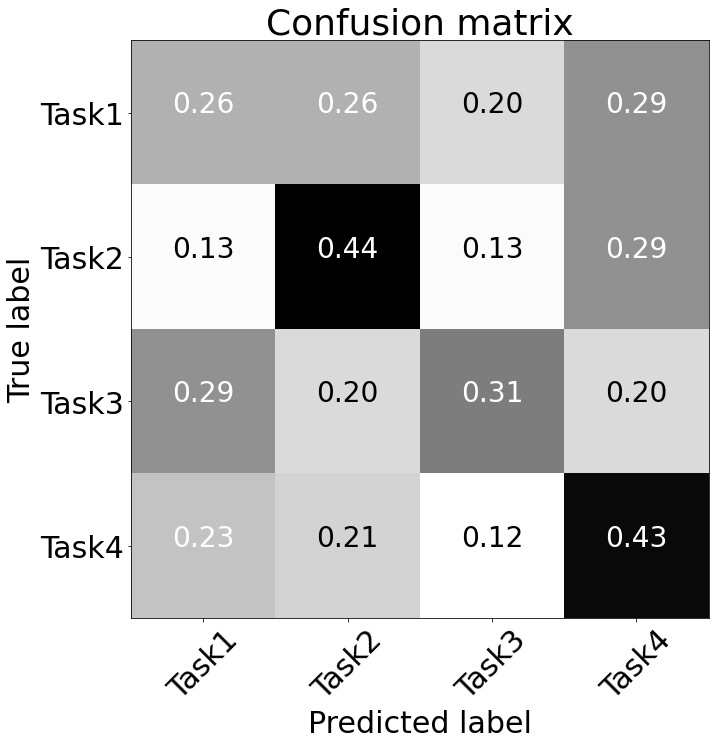

In [16]:
plot_confusion_matrix(cm, ['Task1', 'Task2', 'Task3', 'Task4'], normalize=True, title='Confusion matrix', cmap=plt.cm.Greys)